In [13]:
import os
import sys
import json
from pathlib import Path
sys.path.append(os.path.abspath('..'))

# ----------- local imports ----------- 
from utils import show_images, make_grid
from constants import TRAIN_PATH, TRAIN_JSON_PATH
from FashionDataset import BottomCenterCrop

In [21]:

import cv2
import torch
import numpy as np
import mediapipe as mp
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


In [24]:

image_resize = (1101, 750) # divided by 3 (H, W)
image_crop = (1096, 744) # H, W

transform = transforms.Compose([
    transforms.Resize(image_resize),
    BottomCenterCrop(image_crop),  # Custom bottom-center crop
])

In [25]:
import json

with open(TRAIN_JSON_PATH, 'r') as f:
    train_json = json.load(f)

# Detect Pose

In [ ]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

libEGL warning: DRI3: Screen seems not DRI3 capable
libEGL warning: DRI3: Screen seems not DRI3 capable
I0000 00:00:1741210354.914611   28737 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1741210354.989617   28885 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.2.6 - kisak-mesa PPA), renderer: D3D12 (AMD Radeon(TM) Graphics)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1741210355.128868   28843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741210355.183795   28842 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [6]:
def detect_pose(image):
    image_rgb = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    results = pose.process(image_rgb)
    annotated_image = image.copy()
    
    if results.pose_landmarks:
        mp.solutions.drawing_utils.draw_landmarks(
            annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    
    return annotated_image

In [38]:
poses = []
for entry in tqdm(train_json):
    src, tar = entry['source_image'], entry['target_image']
    src, tar = Image.open(TRAIN_PATH / src), Image.open(TRAIN_PATH / tar)
    src, tar = transform(src), transform(tar)
    # Concatenate images horizontally
    src_tar = Image.new("RGB", (src.width * 2, src.height))
    src_tar.paste(src, (0, 0))
    src_tar.paste(tar, (src.width, 0))
    
    image_rgb = cv2.cvtColor(np.array(src_tar), cv2.COLOR_RGB2BGR)
    results = pose.process(image_rgb)
    annotated_image = image_rgb.copy()
    mp.solutions.drawing_utils.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    break
    # Detect pose
    # src_tar_pose = detect_pose(src_tar)

    src_pose = src_tar_pose.crop((0, 0, src.width, src_tar.height))  # Left half
    tar_pose = src_tar_pose.crop((src.width, 0, src_tar.width, src_tar.height))  # Right half

    # Save result
    poses.append((entry['source_image'], src_pose))
    poses.append((entry['target_image'], tar_pose))
    break

poses

  0%|          | 0/3430 [00:00<?, ?it/s]


[]

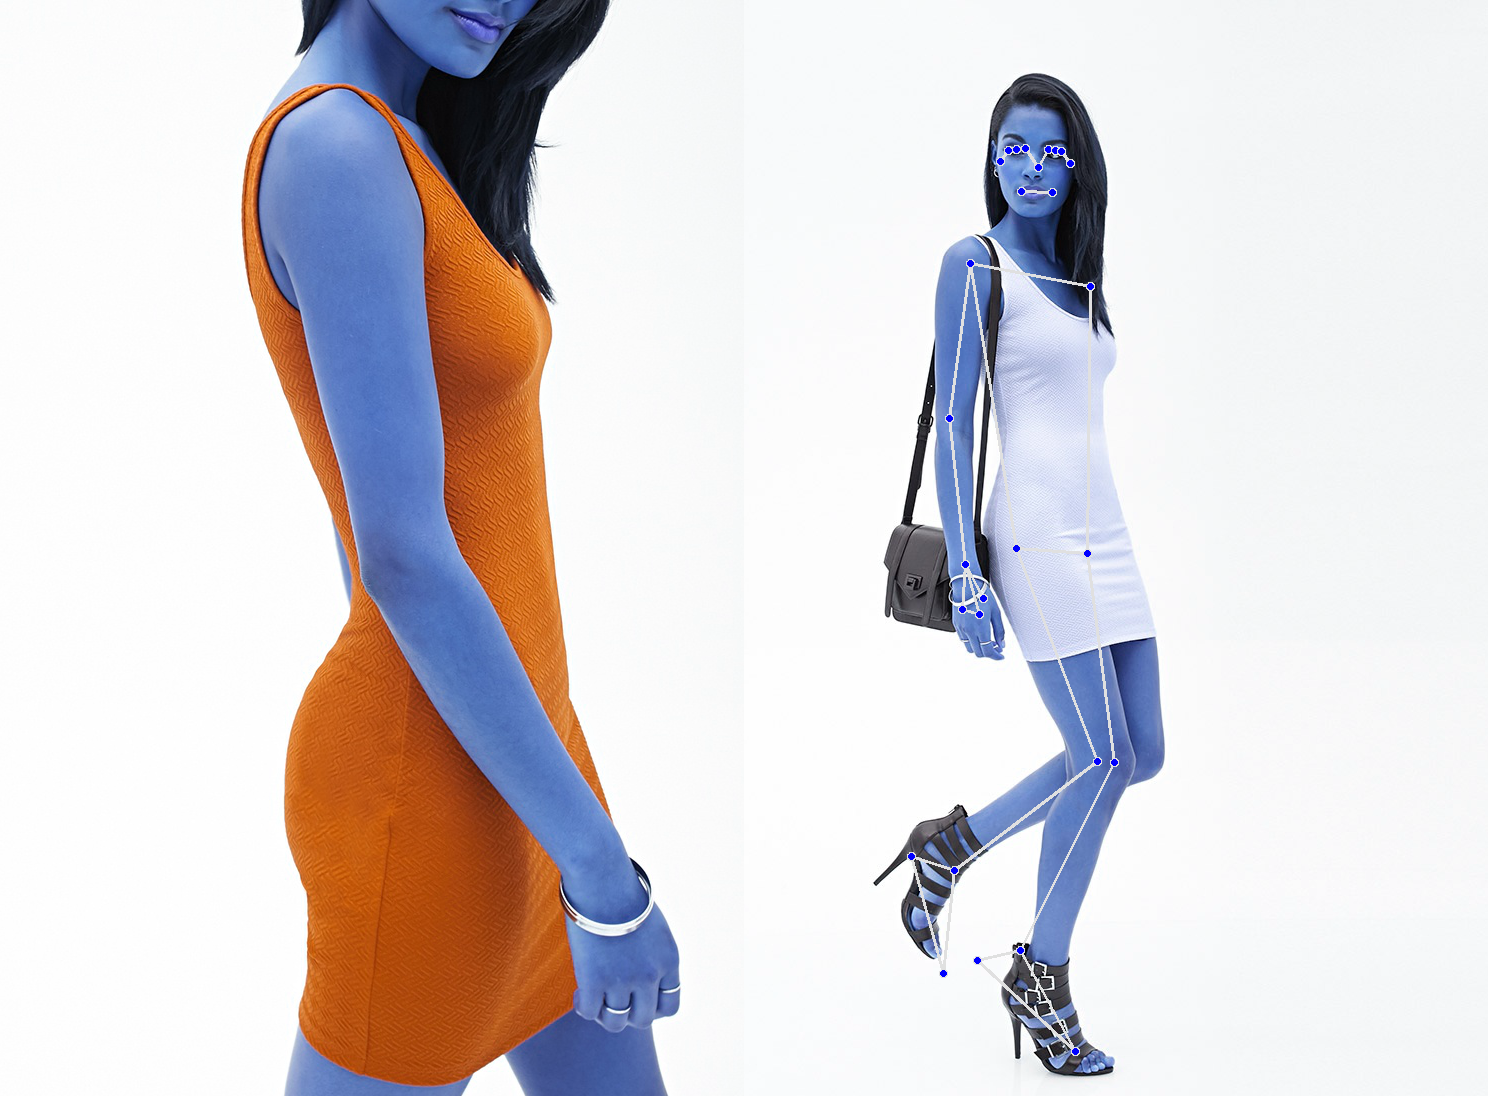

In [40]:
Image.fromarray(annotated_image)

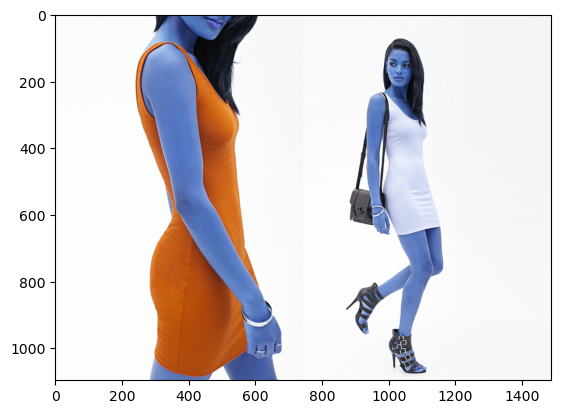

In [32]:
plt.imshow(image_rgb)